In [1]:
from MLfunctions import *
from scipy import stats
from scipy.stats import t
from decimal import *

ModuleNotFoundError: No module named 'MLfunctions'

In [2]:
vars=['falls_in_the_last_year_f2296',
'gender',
'total_dis',
'number_of_treatmentsmedications_taken_f137',
'overall_health_rating_f2178',
'average_total_household_income_before_tax_f738',
'mean_time_to_correctly_identify_matches_f20023']

In [3]:
path='../Data/'

In [4]:
def preprocess(df,agemin,agemax,apoe=2,resize=0,resizeratio=20,target='Dementia'):
    
    mask_age=(df['age_when_attended_assessment_centre_f21003']>=agemin)&\
(df['age_when_attended_assessment_centre_f21003']<=agemax)
    df=df[mask_age]
    df=col_spec_chars(df)
    df=maskapoedf(df,apoe=apoe)
    
    if resize==1:
        mask_disease=(df[target]==1)  
        df_out=pd.concat([df[mask_disease],df[~mask_disease].\
sample(len(df[mask_disease])*resizeratio)],axis=0)
        return df_out
        
    else:
        return df


In [94]:
def lines_conf_mf(var,varname,df,splitvar='Gender',minsamp=2000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='subt',e4e4=0,
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a',depvar='PD'):
    ukb_shap_var=df[['eid',var,splitvar,depvar]]
    
    mask=(ukb_shap_var[splitvar]==1)
    
    #round the variable as necessary
    ukb_shap_var[var+'rounded']=round(ukb_shap_var[var]/factdiv,rounded)*factdiv
    
    print(ukb_shap_var.shape)
    
    dfgp=pd.DataFrame(ukb_shap_var.groupby([splitvar,var+'rounded']).\
agg({depvar:['mean','count','sum']})).reset_index()
    dfgp.columns=[splitvar,var+'rounded',depvar+' Incidence Rate','recs','total_'+depvar]
    mask=(dfgp['recs']>=minsamp)
    dfgp=dfgp[mask]
    ukb_shap_var=pd.merge(ukb_shap_var,dfgp,on=[splitvar,var+'rounded'],how='inner')
    
    #print(dfgp.shape)
    #dfgp_split=pd.DataFrame([])
    uvals=dfgp[splitvar].unique()
    #print(dfgp[splitvar])
    #print(uvals)
    ranges=[]
    statvals=[]
    for i,s in enumerate(uvals):
        #print(i)
        mask=(dfgp[splitvar]==s)
        dfgp_split=dfgp[mask]
        dfgp_split.rename(columns={depvar+' Incidence Rate':str(s)+'_Rate'},inplace=True)
        if i==0:
            dfgp_split_full=dfgp_split.copy()
        else:
            dfgp_split_full=pd.merge(dfgp_split_full,dfgp_split[[var+'rounded',str(s)+'_Rate']],how='inner')
            
            
        mask2=(ukb_shap_var[splitvar]==s)
        print(ukb_shap_var[var].max())
        rng=ukb_shap_var[var].max()-ukb_shap_var[var].min()
        ranges.append(rng)
        slope, intercept, r_value, p_value, std_err = \
stats.linregress(ukb_shap_var[var],ukb_shap_var[depvar])
        statvals.append([slope, intercept, r_value, p_value, std_err])
    
    
    numerator = statvals[0][0] - statvals[1][0]
    denominator = pow((pow(statvals[0][4],2) + pow(statvals[1][4],2)), 1/2)
    z=numerator/denominator  
    print(z)

    p_value = stats.norm.sf(abs(z))
    print('p value :'+str(p_value))
    
    #print(dfgp_split_full)
    #print(uvals)        
    if rat=='mult':
        yname='Ratio: '+str(uvals[0])+" to "+str(uvals[1])+' Incidence'
        dfgp_split_full[yname]=dfgp_split_full[str(uvals[0])+'_Rate']/dfgp_split_full[str(uvals[1])+'_Rate']
    elif rat=='subt':
        yname='Difference: '+str(uvals[0])+" to "+str(uvals[1])+' Incidence'
        dfgp_split_full[yname]=dfgp_split_full[str(uvals[0])+'_Rate']-dfgp_split_full[str(uvals[1])+'_Rate']
        
    if riskscore==0:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y=depvar,hue=splitvar,estimator='mean',
                        palette = pal)
        ax.set(xlabel=varname,ylabel='% '+depvar+' within 10 years')
        
        if leg==0:
            ax.get_legend().remove()
        
        plt.xticks(fontsize='18')
        plt.yticks(fontsize='18')
        plt.xlabel(varname, fontsize=18)
        plt.ylabel('% '+depvar+' within 10 years', fontsize=18)
    plt.show()
   
    

In [5]:
def lines_conf(var,varname,df,minsamp=2000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='subt',e4e4=0,
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a',depvar='PD'):
    #ukb_shap_var=df[['eid',var,'APOE','Genotype','AD','risk_score_norm']]
    
    ukb_shap_var=df[['eid',var,'Genotype_e3/e4','Genotype_e4/e4','Genotype_e2/e4',depvar]]
    
   
    
    mask=(df['Genotype_e3/e4']==1)|(df['Genotype_e4/e4']==1)|(df['Genotype_e2/e4']==1)
    maske4=(df['Genotype_e4/e4']==1)
    ukb_shap_var['APOE Status']='Non APOE Carriers'
    
    ukb_shap_var['APOE Status'][mask]='APOE4 Carriers'
    if e4e4==1:
        ukb_shap_var['APOE Status'][mask]='Single APOE4 Carriers'
        ukb_shap_var['APOE Status'][maske4]='APOE4 Carriers e4/e4'
        
    else:
        ukb_shap_var['APOE Status'][mask]='APOE4 Carriers'
    
    
    
    ukb_shap_var[var+'rounded']=round(ukb_shap_var[var]/factdiv,rounded)*factdiv
    dfgp=pd.DataFrame(ukb_shap_var.groupby(['APOE Status',var+'rounded']).\
agg({depvar:['mean','count','sum']})).reset_index()
    dfgp.columns=['APOE Status',var+'rounded',depvar+' Incidence Rate','recs','total_'+depvar]
    mask=(dfgp['recs']>=minsamp)
    dfgp=dfgp[mask]
    ukb_shap_var=pd.merge(ukb_shap_var,dfgp,on=['APOE Status',var+'rounded'],how='inner')
    
    if e4e4==1:
        maskapoe=(dfgp['APOE Status']=='Single APOE4 Carriers')|(dfgp['APOE Status']=='APOE4 Carriers e4/e4')
    else:
        maskapoe=(dfgp['APOE Status']=='APOE4 Carriers')
    
    dfgp_apoe=dfgp[maskapoe]
    dfgp_apoe.rename(columns={depvar+' Incidence Rate':'APOERate'},inplace=True)
    dfgp_non_apoe=dfgp[~maskapoe]
    dfgp_non_apoe.rename(columns={depvar+' Incidence Rate':'nonAPOERate'},inplace=True)
    df_gp_apoenon=pd.merge(dfgp_apoe[[var+'rounded','APOERate']],
                           dfgp_non_apoe[[var+'rounded','nonAPOERate']],on=var+'rounded',how='inner')
    
    if rat=='mult':
        yname='Ratio: APOE4 to non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']/df_gp_apoenon['nonAPOERate']
    elif rat=='subt':
        yname='Difference: APOE4 - non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']-df_gp_apoenon['nonAPOERate']
    
    
    #plt.show()
    
    if riskscore==0:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y=depvar,hue='APOE Status',estimator='mean',
                        palette = pal)
        ax.set(xlabel=varname,ylabel='% '+depvar+' within 10 years')
        
        if leg==0:
            ax.get_legend().remove()
        if leg==1:
            plt.setp(axs[i,j].get_legend().get_texts(), fontsize='22') # for legend text
            plt.setp(axs[i,j].get_legend().get_title(), fontsize='32') # for legend title
        plt.xticks(fontsize='18')
        plt.yticks(fontsize='18')
        plt.xlabel(varname, fontsize=18)
        plt.ylabel('% '+depvar+' within 10 years', fontsize=18)
        #plt.text(0.5,0.5,'p value slopes'+str(pval))
        
        print(pval)
        
        if pval<0.01:
            symb="**"
        elif pval<0.05:
            symb="*"
        else:
            symb=" (ns)"
        
        if round(pval,4)==0:
            valsymb="{:.2E}".format(Decimal(pval))
        else:
            valsymb=str(round(pval,5))
        plt.text(0.6,0.9,'slope ratios: '+"{:.0%}".format(slope_diff),horizontalalignment='center',
                 verticalalignment='center', transform = ax.transAxes, fontsize='18')
        plt.text(0.5,0.8,'(p = '+valsymb+symb+')',horizontalalignment='center',
                 verticalalignment='center', transform = ax.transAxes, fontsize='18')
        plt.savefig('fig3'+figord+"_"+var+'.svg', dpi=300)
        plt.show()
        

        
    if riskscore==1:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y='risk_score_norm',hue='APOE Status',estimator='mean',
                        palette = pal)
        ax.set(xlabel=varname,ylabel='% '+depvar+' within 10 years')
        ax.get_legend().remove()
        #plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
        plt.xticks(fontsize='16')
        plt.yticks(fontsize='16')
        plt.xlabel(varname, fontsize=18)
        plt.ylabel('% '+depvar+' within 10 years', fontsize=16)
        

        plt.show()
        
    
    
    if regplot==1:
        #sns.lineplot(data=df_gp_apoenon, x=var+'rounded', y='ratio',estimator='mean')
        sns.regplot(data=df_gp_apoenon, x=var+'rounded', y=yname)
        plt.show()
        
        slope, intercept, r_value, p_value, std_err = \
        stats.linregress(df_gp_apoenon[var+'rounded'],df_gp_apoenon[yname])

        x=df_gp_apoenon[var+'rounded']
        tinv = lambda p, df: abs(t.ppf(p/2, df))
        ts = tinv(0.05, len(x)-2)
        slope_CI=ts*std_err
        print(f"slope (95%): {slope:.6f} +/- {slope_CI:.6f}")
        #sns.regplot(data=dfgp, x=var+'rounded', y='AD Incidence Rate')
        #plt.show()
    else:
        pass

In [ ]:
def pvalue_slopes(df,var,splitvar='gender',depvar='Dementia'):
    
    mask_aspnnull=(pd.notnull(df[var]))
    apoe_mask=(df['Genotype_e3/e4']==1)|(df['Genotype_e3/e4']==1)|(df['Genotype_e2/e4']==1)
    
    rng_apoe=(df[mask_aspnnull&apoe_mask][var].max()-df[mask_aspnnull&apoe_mask][var].min())
    
    slope_ap, intercept_ap, r_value_ap, p_value_ap, std_err_ap = \
    stats.linregress(df[mask_aspnnull&apoe_mask][var],df[mask_aspnnull&apoe_mask][depvar])
    
    slope_ap_fin=slope_ap*rng_apoe
    
    
    x=df[mask_aspnnull&apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    apoe_CI=ts*std_err_ap*rng_apoe

    
    #from scipy.stats import t
    #tinv = lambda p, df: abs(t.ppf(p/2, df)
    
        #print(slope_ap)
    rng_nonapoe=df[mask_aspnnull&~apoe_mask][var].max()-df[mask_aspnnull&~apoe_mask][var].min()
    
    slope_nonap, intercept_nonap, r_value_nonap, p_value_nonap, std_err_nonap = \
    stats.linregress(df[mask_aspnnull&~apoe_mask][var],df[mask_aspnnull&~apoe_mask][depvar])
    #print(slope_nonap)
    
    slope_nonap_fin=slope_nonap*rng_nonapoe
    
    x=df[mask_aspnnull&~apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    nonapoe_CI=ts*std_err_ap*rng_nonapoe

    numerator = slope_ap - slope_nonap
    denominator = pow((pow(std_err_ap,2) + pow(std_err_nonap,2)), 1/2)
    z=numerator/denominator  
    #print(z)

    p_value = stats.norm.sf(abs(z))
    
    slope_diff=slope_ap_fin-slope_nonap_fin
    
    slope_rat=slope_ap_fin/slope_nonap_fin
    
    print('Slope Difference: '+str(slope_diff))
    print('Slope Ratio: '+str(slope_rat))
    
    
    return slope_rat,p_value

In [6]:

def pvalue_slopes(df,var,depvar='Dementia'):
    
    mask_aspnnull=(pd.notnull(df[var]))
    apoe_mask=(df['Genotype_e3/e4']==1)|(df['Genotype_e3/e4']==1)|(df['Genotype_e2/e4']==1)
    
    rng_apoe=(df[mask_aspnnull&apoe_mask][var].max()-df[mask_aspnnull&apoe_mask][var].min())
    
    slope_ap, intercept_ap, r_value_ap, p_value_ap, std_err_ap = \
    stats.linregress(df[mask_aspnnull&apoe_mask][var],df[mask_aspnnull&apoe_mask][depvar])
    
    slope_ap_fin=slope_ap*rng_apoe
    
    
    x=df[mask_aspnnull&apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    apoe_CI=ts*std_err_ap*rng_apoe

    
    #from scipy.stats import t
    #tinv = lambda p, df: abs(t.ppf(p/2, df)
    
        #print(slope_ap)
    rng_nonapoe=df[mask_aspnnull&~apoe_mask][var].max()-df[mask_aspnnull&~apoe_mask][var].min()
    
    slope_nonap, intercept_nonap, r_value_nonap, p_value_nonap, std_err_nonap = \
    stats.linregress(df[mask_aspnnull&~apoe_mask][var],df[mask_aspnnull&~apoe_mask][depvar])
    #print(slope_nonap)
    
    slope_nonap_fin=slope_nonap*rng_nonapoe
    
    x=df[mask_aspnnull&~apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    nonapoe_CI=ts*std_err_ap*rng_nonapoe

    numerator = slope_ap - slope_nonap
    denominator = pow((pow(std_err_ap,2) + pow(std_err_nonap,2)), 1/2)
    z=numerator/denominator  
    #print(z)

    p_value = stats.norm.sf(abs(z))
    
    slope_diff=slope_ap_fin-slope_nonap_fin
    
    slope_rat=slope_ap_fin/slope_nonap_fin
    
    print('Slope Difference: '+str(slope_diff))
    print('Slope Ratio: '+str(slope_rat))
    
    
    return slope_rat,p_value

In [290]:
dem_model_bor=pd.read_parquet('%s%s' % (path,'dem_model_bor.parquet'))

In [9]:
dem_model_allcols=pd.read_parquet('%s%s' % (path,'dem_model_allcols_bmi.parquet'))

In [10]:
PD_model_allcols=pd.read_parquet('%s%s' % (path,'PD_model_allcols_bmi.parquet'))

In [36]:
PD_model_allcols.groupby('smoking_status_f20116_Current').agg({'PD':['mean','sum','count']})
#'current_tobacco_smoking_f1239'
#how well does the model without the smoking as an input variable impact the smokers subgroup?

PD                
                                   mean     sum   count
current_tobacco_smoking_f1239                          
0.0                            0.004460  1923.0  431137
1.0                            0.002454    32.0   13040
2.0                            0.002798   100.0   35740

In [25]:
findcols (PD_model_allcols,'gend')

['gender']

In [18]:
PD_model_allcols[PD_model_allcols['coffee_intake_f1498'].isin([0,1,2,3,4])].groupby('coffee_intake_f1498')['PD'].mean()

coffee_intake_f1498
0.0    0.003935
1.0    0.004518
2.0    0.004349
3.0    0.004449
4.0    0.004462
Name: PD, dtype: float64

(481180, 5)
10.0
10.0
0.0
p value :0.5


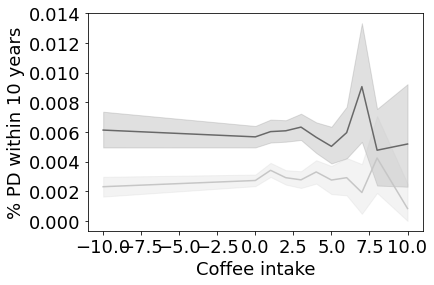

(481180, 5)
37.4991860403328
37.4991860403328
0.0
p value :0.5


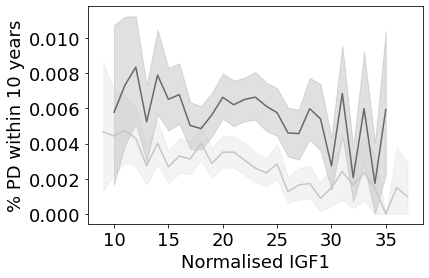

(481180, 5)
70.0
70.0
0.0
p value :0.5


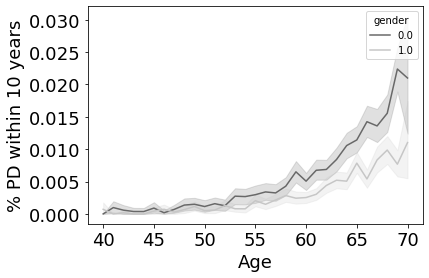

(481180, 5)
2.0
2.0
0.0
p value :0.5


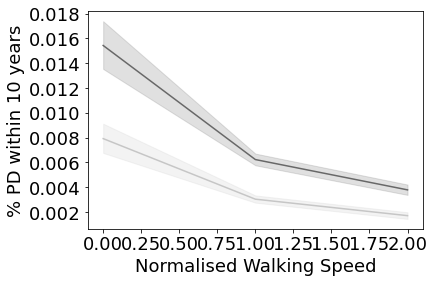

In [95]:
lines_conf_mf(var='coffee_intake_f1498',varname='Coffee intake',df=PD_model_allcols,splitvar='gender',
              minsamp=1000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='mult',
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a',depvar='PD')

lines_conf_mf(var='igf_agenorm',varname='Normalised IGF1',df=PD_model_allcols,splitvar='gender',
              minsamp=1000,regplot=0,rounded=1,factdiv=10,riskscore=0,rat='mult',
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a',depvar='PD')
lines_conf_mf(var='age_when_attended_assessment_centre_f21003',varname='Age',df=PD_model_allcols,splitvar='gender',
              minsamp=1000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='mult',
              pal='Greys_r',leg=1,pval=0.05,slope_diff=0.5,figord='a',depvar='PD')

lines_conf_mf(var='usual_walking_pace_f924',varname='Normalised Walking Speed',df=PD_model_allcols,splitvar='gender',
              minsamp=1000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='mult',
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a',depvar='PD')




In [31]:
findcols(PD_model_allcols,'smok')

['smoking_status_f20116_Current',
 'smoking_status_f20116_Never',
 'smoking_status_f20116_Previous',
 'current_tobacco_smoking_f1239',
 'past_tobacco_smoking_f1249',
 'smokingsmokers_in_household_f1259',
 'maternal_smoking_around_birth_f1787',
 'ever_smoked_f20160',
 'exposure_to_tobacco_smoke_at_home_f1269',
 'exposure_to_tobacco_smoke_outside_home_f1279',
 'smok_Current',
 'smok_Never',
 'smok_Prefer not to answer',
 'smok_Previous']

In [237]:
dem_model_bor2=preprocess(df=dem_model_bor,agemin=55,agemax=70)

In [238]:
dem_model_allcols2=preprocess(df=dem_model_allcols,agemin=55,agemax=70)

In [170]:
pvalue_slopes(dem_model_bor2,'age_when_attended_assessment_centre_f21003')

Slope Difference: 0.03076682810627098
Slope Ratio: 2.643893460412108


(0.03076682810627098, 3.0030207033172957e-55)

In [171]:
pvalue_slopes(dem_model_bor2,'average_total_household_income_before_tax_f738')

Slope Difference: -0.008695184528212016
Slope Ratio: 1.9481480076544855


(-0.008695184528212016, 6.675492249513681e-06)

In [178]:
pvalue_slopes(dem_model_bor2,'mean_time')

Slope Difference: 0.04074012060115737
Slope Ratio: 1.850201009906865


(0.04074012060115737, 2.672115393390173e-10)

In [11]:
def pvalslopes(df=dem_model_allcols,var='age_when_attended_assessment_centre_f21003',varname='Age at Baseline',
               rounded=0,factdiv=1,depvar='Dementia'):
    pval=pvalue_slopes(df,var,depvar=depvar)
    lines_conf(var=var,varname=varname,df=df,minsamp=2000,regplot=0,\
    rounded=1,factdiv=factdiv,riskscore=0,rat='subt',e4e4=1,pal='Greys_r',leg=0,
               pval=pval[1],slope_diff=pval[0],figord='a',depvar=depvar)
    

Slope Difference: -0.006546566077398962
Slope Ratio: 1.8375287302900438
2.1661285249681748e-10


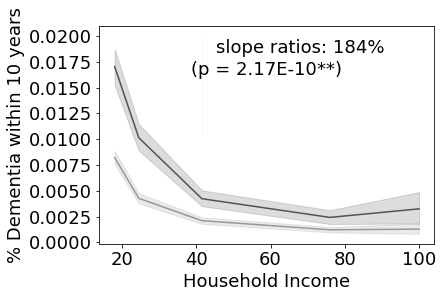

In [14]:
pvalslopes(var='average_total_household_income_before_tax_f738',varname='Household Income')


Slope Difference: 0.018632040266392542
Slope Ratio: -7.932074021390218
1.78880469139368e-05


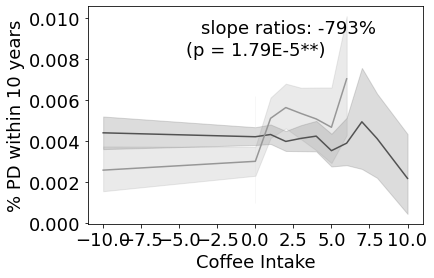

In [12]:
pvalslopes(var='coffee_intake_f1498',varname='Coffee Intake',depvar='PD',df=PD_model_allcols)

Slope Difference: -0.006421501312731942
Slope Ratio: -0.3434728202393892
0.010088914535675687


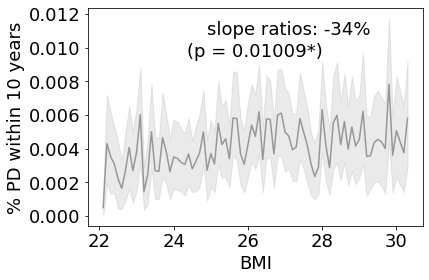

In [30]:
pvalslopes(var='body_mass_index_bmi_f21001_0_0',varname='BMI',depvar='PD',df=PD_model_allcols)

Slope Difference: -0.0035269994532091016
Slope Ratio: 0.2940352721248206
0.18227078436924066


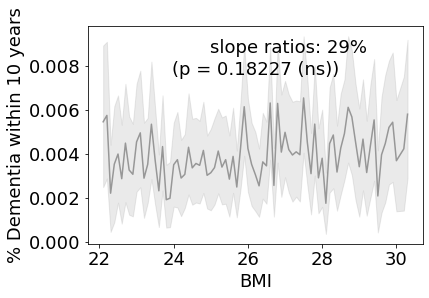

In [15]:
pvalslopes(var='body_mass_index_bmi_f21001_0_0',varname='BMI')

Slope Difference: 0.0018444645097837487
Slope Ratio: 1.365152567952012
0.16195160717324336


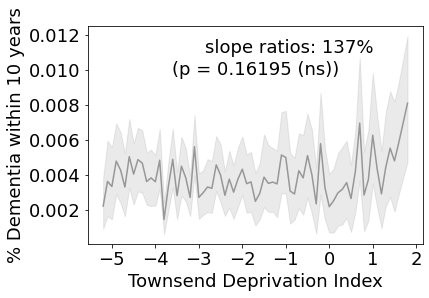

In [16]:
pvalslopes(var='townsend_deprivation_index_at_recruitment_f189_0_0',varname='Townsend Deprivation Index')


Slope Difference: 0.004828991557227805
Slope Ratio: 1.3882315827274192
0.006408802256887824


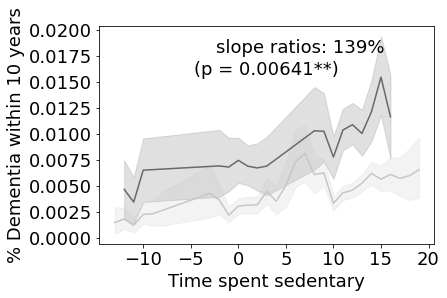

In [17]:
pvalslopes(var='sed_time',varname='Time spent sedentary')

Slope Difference: 0.03076682810627098
Slope Ratio: 2.643893460412108
3.0030207033172957e-55


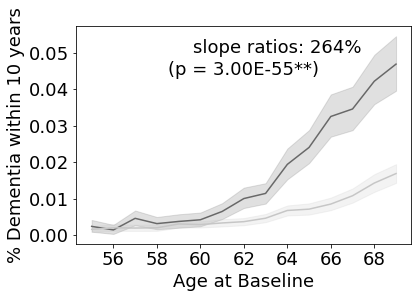

Slope Difference: -0.008695184528212016
Slope Ratio: 1.9481480076544855
6.675492249513681e-06


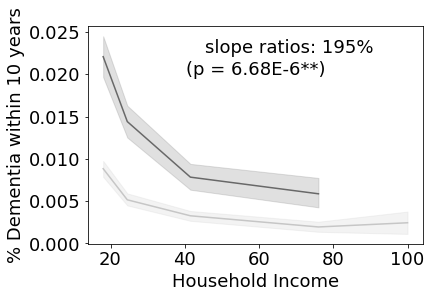

Slope Difference: -0.0004030628908946801
Slope Ratio: 1.1515121597692597
0.35427064646294404


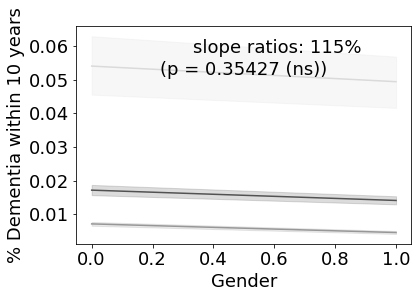

In [223]:
pvalslopes(var='age_when_attended_assessment_centre_f21003')
pvalslopes(var='average_total_household_income_before_tax_f738',varname='Household Income')
pvalslopes(var='gender',varname='Gender')

Slope Difference: 0.031355298411955904
Slope Ratio: 1.6487320653624444
8.364954231996272e-09


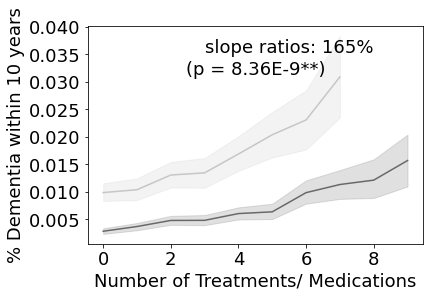

Slope Difference: 0.07975104832918885
Slope Ratio: 2.067469859742724
4.300160541288691e-13


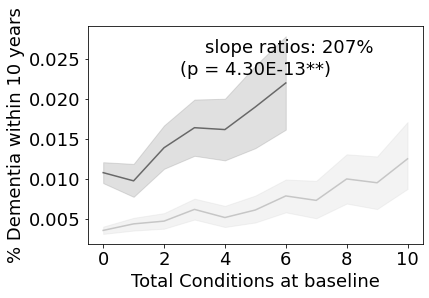

In [224]:
pvalslopes(var='number_of_treatmentsmedications_taken_f137',varname='Number of Treatments/ Medications')
pvalslopes(var='total_dis',varname='Total Conditions at baseline')

Slope Difference: 0.019244269396813646
Slope Ratio: 1.4390653851789024
3.516253274229748e-05


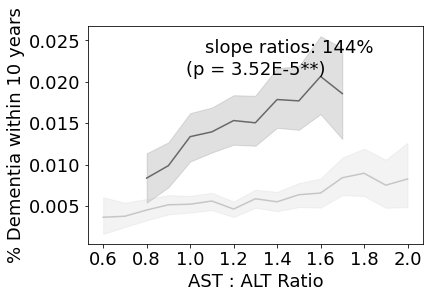

Slope Difference: -0.011002129392046325
Slope Ratio: 0.7409652062589624
0.46354430770057276


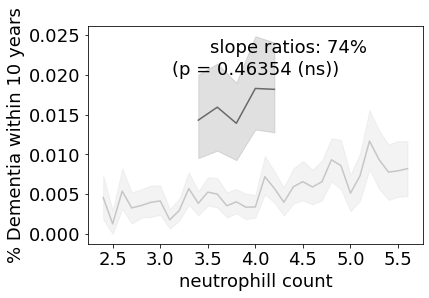

In [225]:
pvalslopes(var='AST_ALT_ratio',varname='AST : ALT Ratio')
pvalslopes(var='neutrophill_count_f30140',varname='neutrophill count')

Slope Difference: 0.04074012060115737
Slope Ratio: 1.850201009906865
2.672115393390173e-10


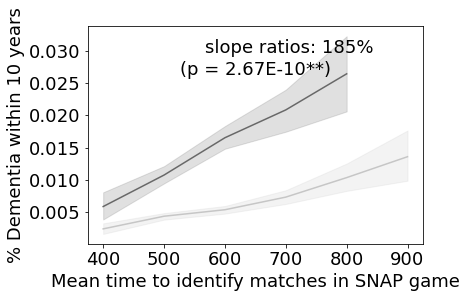

In [222]:
pvalslopes(var='mean_time',varname='Mean time to identify matches in SNAP game',
          rounded=0,factdiv=1)

In [211]:
findcols(dem_model_bor2,'mean_time')

['mean_time_to_correctly_identify_matches_f20023', 'mean_time']

Slope Difference: -0.008695184528212016
Slope Ratio: 1.9481480076544855
6.675492249513681e-06


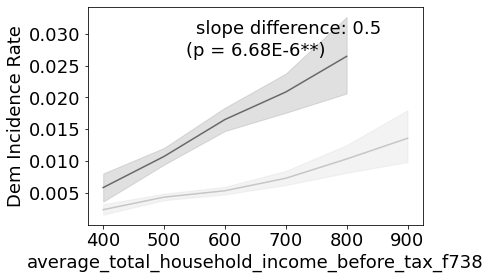

In [197]:
pval=pvalue_slopes(dem_model_bor2,'average_total_household_income_before_tax_f738')[1]
lines_conf(var='mean_time',varname='average_total_household_income_before_tax_f738',df=dem_model_bor2,minsamp=2000,regplot=0,\
rounded=1,factdiv=1,riskscore=0,rat='subt',e4e4=1,pal='Greys_r',leg=0,pval=pval,slope_diff=0.5,figord='a')

In [ ]:
demvars=['average_total_household_income_before_tax_f738','age_when_attended_assessment_centre_f21003','gender']
chemvars=['AST_ALT_ratio','neutrophill_count']
healthvars=['number_of_treatmentsmedications_taken_f137','total_dis']

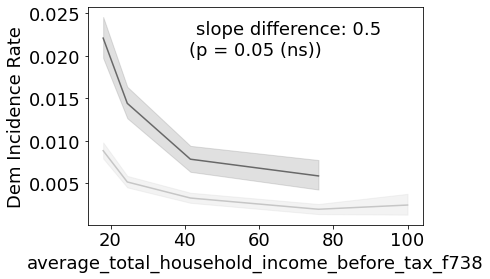

In [185]:
lines_conf(var='average_total_household_income_before_tax_f738',
           varname='average_total_household_income_before_tax_f738',df=dem_model_bor2,minsamp=2000,
           regplot=0,rounded=1,\
factdiv=1,riskscore=0,rat='subt',e4e4=1,pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a')

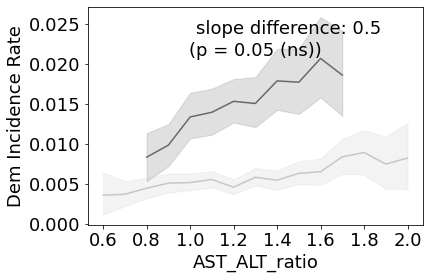

In [186]:
lines_conf(var='AST_ALT_ratio',
           varname='AST_ALT_ratio',df=dem_model_bor2,minsamp=2000,regplot=0,rounded=1,\
factdiv=1,riskscore=0,rat='subt',e4e4=1,pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a')

#### OLD

In [245]:
ast_cols=['alanine_aminotransferase_f30620','aspartate_aminotransferase_f30650']

In [249]:
for col in ast_cols:
    dem_model_allcols2[col+'_quint']=pd.qcut(dem_model_allcols2[col],5,labels=False)

In [274]:
findcols(dem_model_allcols2,'age_when')

['age_when_attended_assessment_centre_f21003']

In [277]:
dem_model_allcols2[(dem_model_allcols2['Dementia']==1)].groupby(['APOE4_Carriers'])\
['age_when_attended_assessment_centre_f21003'].mean()

APOE4_Carriers
0.0    64.853634
1.0    65.443158
2.0    64.982143
Name: age_when_attended_assessment_centre_f21003, dtype: float64

In [279]:
findcols(dem_model_allcols2,'Dementia')

['Dementia', 'Dementia_date', 'daystoDementia']

In [283]:
dem_model_allcols2['Age_dementia']=dem_model_allcols2['age_when_attended_assessment_centre_f21003']+\
dem_model_allcols2['daystoDementia']/365.25

In [284]:
dem_model_allcols2[(dem_model_allcols2['Dementia']==1)].groupby(['APOE4_Carriers'])\
['Age_dementia'].mean()

APOE4_Carriers
0.0    72.425747
1.0    73.102183
2.0    72.494238
Name: Age_dementia, dtype: float64

In [250]:
for col in ast_cols:
    print(dem_model_allcols2[col+'_quint'].value_counts())

1.0    45374
0.0    45367
3.0    45290
4.0    45286
2.0    45282
Name: alanine_aminotransferase_f30620_quint, dtype: int64
0.0    45934
3.0    45470
2.0    45142
1.0    44778
4.0    44594
Name: aspartate_aminotransferase_f30650_quint, dtype: int64


In [257]:
ASTALT=pd.DataFrame(dem_model_allcols2.groupby([col+'_quint' for col in ast_cols])['Dementia'].mean()).reset_index()

In [268]:
ASTALT.sort_values(by=[col+'_quint' for col in ast_cols],inplace=True)

In [269]:
ast_alt_piv=ASTALT.pivot(index='aspartate_aminotransferase_f30650_quint', \
columns='alanine_aminotransferase_f30620_quint', values='Dementia')

In [271]:
ast_alt_piv

alanine_aminotransferase_f30620_quint,0.0,1.0,2.0,3.0,4.0
aspartate_aminotransferase_f30650_quint,,,,,
0.0,0.009607,0.009078,0.005918,0.006494,0.006881
1.0,0.010815,0.008608,0.007899,0.006553,0.004375
2.0,0.013764,0.009330,0.008663,0.008344,0.005950
3.0,0.021097,0.012315,0.009289,0.008774,0.004420
4.0,0.013665,0.017186,0.014409,0.012413,0.008938


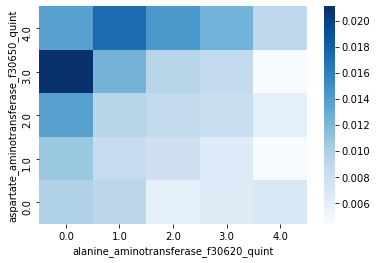

In [272]:
ax = sns.heatmap(ast_alt_piv,cmap="Blues")
ax.invert_yaxis()

In [265]:
heat_map = sns.heatmap(ast_alt_piv,cmap="B")


ValueError: 'green' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [243]:
findcols(dem_model_allcols2,'aspar')

['aspartate_aminotransferase_correction_level_f30653_Date and aliquot correction',
 'aspartate_aminotransferase_correction_level_f30653_Date correction only',
 'aspartate_aminotransferase_correction_reason_f30654_No aliquot information',
 'aspartate_aminotransferase_correction_reason_f30654_Normal for assay type',
 'aspartate_aminotransferase_reportability_f30656_Not reportable at assay (too high)',
 'aspartate_aminotransferase_reportability_f30656_Not reportable at assay (too low)',
 'aspartate_aminotransferase_reportability_f30656_Reportable at assay and after aliquot correction_ if attempted',
 'aspartate_aminotransferase_aliquot_f30652',
 'aspartate_aminotransferase_f30650']

In [91]:
apoemap=dict({'Genotype_e4/e4':"APOE4 Carrier",\
 'Genotype_e3/e4':"APOE4 Carrier",\
 'Genotype_e3/e3':"Non APOE4 Carrier",\
 'Genotype_e2/e3':"Non APOE4 Carrier",\
 'Genotype_e1/e2':"Non APOE4 Carrier",\
 'Genotype_e1/e4':"Non APOE4 Carrier",\
 'Genotype_e2/e2':"Non APOE4 Carrier",\
 'Genotype_e2/e4':"APOE4 Carrier"})

In [100]:
print(dem_model_bor2.groupby('Dementia')['age_when_attended_assessment_centre_f21003'].mean())
print(dem_model_bor2.groupby('Dementia')['age_when_attended_assessment_centre_f21003'].std())

Dementia
0.0    61.929984
1.0    65.123697
Name: age_when_attended_assessment_centre_f21003, dtype: float64
Dementia
0.0    4.065751
1.0    3.474243
Name: age_when_attended_assessment_centre_f21003, dtype: float64


In [93]:
dem_model_bor2['APOE']=dem_model_bor2.apply(lambda x:1 if x['Genotype_e3/e4']==1 or
                                            x['Genotype_e4/e4']==1 or x['Genotype_e2/e4']==1
                    else 0,axis=1)

KeyboardInterrupt: 

<AxesSubplot:xlabel='average_total_household_income_before_tax_f738'>

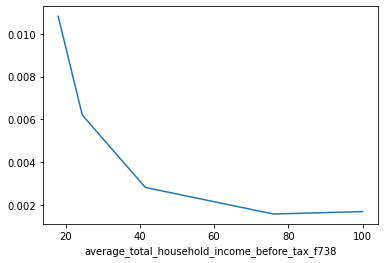

In [101]:
dem_model_bor.groupby(['average_total_household_income_before_tax_f738'])['Dementia'].mean().plot()

In [102]:
findcols(dem_model_bor,'testosterone')

['testosterone_f30850']

In [104]:
dem_model_bor['APOE']='None'
dem_model_bor['APOE'][(dem_model_bor['Genotype_e3/e4']==1)]="E3/E4"
dem_model_bor['APOE'][(dem_model_bor['Genotype_e4/e4']==1)]="E4/E4"

<AxesSubplot:xlabel='average_total_household_income_before_tax_f738', ylabel='Dementia'>

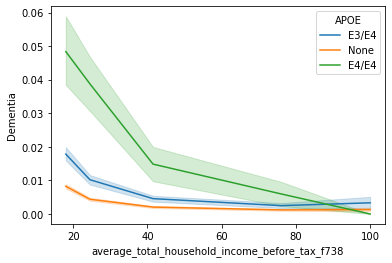

In [69]:
sns.lineplot(x='average_total_household_income_before_tax_f738',y='Dementia',data=dem_model_bor,
            hue='APOE')

In [177]:
mask=(pd.notnull(dem_model_bor['mean_time_to_correctly_identify_matches_f20023']))
dem_model_bor2['mean_time']=np.nan
dem_model_bor2['mean_time'][mask]=\
dem_model_bor2['mean_time_to_correctly_identify_matches_f20023'][mask].apply(lambda x:100*round(x/100))

In [111]:
dem_model_bor['testosterone_f30850'][pd.notnull(dem_model_bor['testosterone_f30850'])].\
apply(lambda x:round(x)).nunique()

53

In [132]:
mask=pd.notnull(dem_model_bor['testosterone_f30850'])
mask_gen=(dem_model_bor['gender']==1)

In [122]:
dem_model_bor['testosterone']=0
dem_model_bor['testosterone'][mask]=dem_model_bor['testosterone_f30850'][mask].\
apply(lambda x:5*round(x/5))

In [139]:
ubdtest=dem_model_bor[mask&~mask_gen]['testosterone'].quantile(0.95)
lbdtest=dem_model_bor[mask&~mask_gen]['testosterone'].quantile(0.05)
maskquants=(dem_model_bor['testosterone']<=ubdtest)&(dem_model_bor['testosterone']>=lbdtest)

<AxesSubplot:xlabel='testosterone', ylabel='Dementia'>

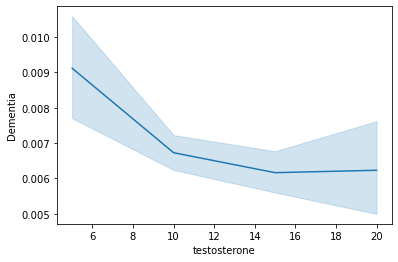

In [140]:
sns.lineplot(x='testosterone',y='Dementia',data=dem_model_bor[mask&~mask_gen&maskquants])

In [145]:
mask=pd.notnull(dem_model_bor['shbg_f30830'])
dem_model_bor['shbg']=0
dem_model_bor['shbg'][mask]=dem_model_bor['shbg_f30830'][mask].\
apply(lambda x:5*round(x/5))
dem_model_bor['shbg'].nunique()

49

In [153]:
dem_model_bor['shbg'].quantile(0.99)

145.0

<AxesSubplot:xlabel='shbg', ylabel='Dementia'>

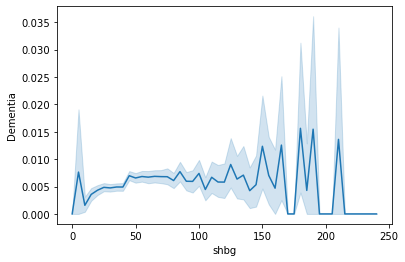

In [146]:
sns.lineplot(x='shbg',y='Dementia',data=dem_model_bor[mask])

In [ ]:
sns.lineplot(x='testosterone',y='Dementia',data=dem_model_bor[mask&~mask_gen])

In [126]:
findcols(dem_model_bor,'gend')

['gender']

gender
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: testosterone, dtype: object

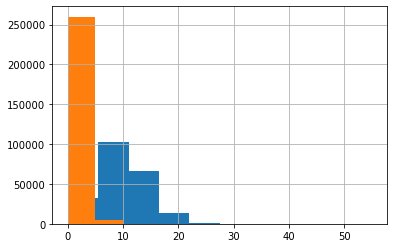

In [130]:
dem_model_bor.groupby('gender')['testosterone'].hist()

0.9228531596579205


<AxesSubplot:xlabel='number_of_treatmentsmedications_taken_f137', ylabel='Dementia'>

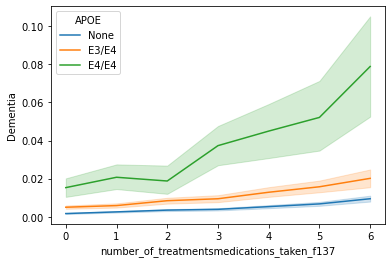

In [73]:
mask=(dem_model_bor['number_of_treatmentsmedications_taken_f137']<=6)
print(dem_model_bor[mask].shape[0]/dem_model_bor.shape[0])
sns.lineplot(x='number_of_treatmentsmedications_taken_f137',y='Dementia',data=dem_model_bor[mask],
            hue='APOE')


<AxesSubplot:xlabel='falls_in_the_last_year_f2296'>

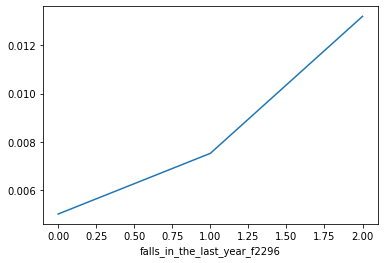

In [64]:
dem_model_bor.groupby(['falls_in_the_last_year_f2296'])['Dementia'].mean().plot()

In [74]:
dem_model_bor2=preprocess(df=dem_model_bor,agemin=55,agemax=70,apoe=2)

In [77]:
dem_model_bor2['Dementia'].sum()

2207.0

In [45]:
findcols(dem_model_bor,'neutro')

['neutrophill_percentage_f30200', 'neutrophill_count_f30140']

In [33]:
dem_model_bor['AST_ALT_ratio'].nunique()

75

In [15]:
dem_model_bor['mean_time']=\
dem_model_bor['mean_time_to_correctly_identify_matches_f20023'].apply(lambda x:100*round(x/100))

<AxesSubplot:xlabel='mean_time'>

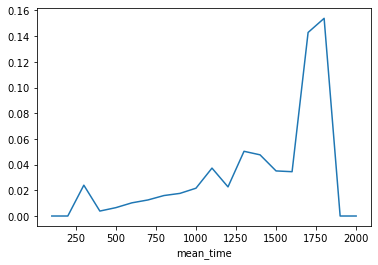

In [16]:

dem_model_bor.groupby(['mean_time'])['Dementia'].mean().plot()

<AxesSubplot:xlabel='overall_health_rating_f2178'>

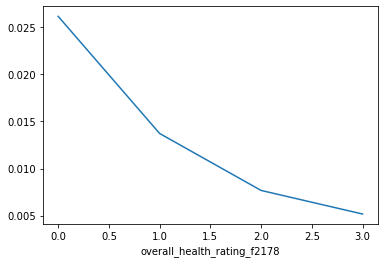

In [29]:
dem_model_bor[(dem_model_bor['overall_health_rating_f2178'].apply(float.is_integer))]\
.groupby(['overall_health_rating_f2178'])['Dementia'].mean().plot()

<AxesSubplot:xlabel='total_dis'>

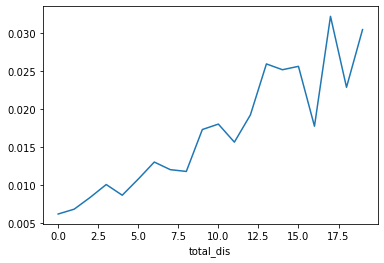

In [31]:
dem_model_bor[(dem_model_bor['total_dis'].apply(float.is_integer))&(dem_model_bor['total_dis']<20)]\
.groupby(['total_dis'])['Dementia'].mean().plot()


In [18]:
dem_model_bor['overall_health_rating_f2178'].value_counts()

2.000000    141229
1.000000     48321
3.000000     38272
0.000000      8871
1.882586      1247
Name: overall_health_rating_f2178, dtype: int64

In [21]:
dem_model_bor['overall_health_rating_f2178'].apply(lambda x:True if round(x)==x)

SyntaxError: invalid syntax (<ipython-input-21-ba2a66f4e7a0>, line 1)

<AxesSubplot:xlabel='AST_ALT_ratio'>

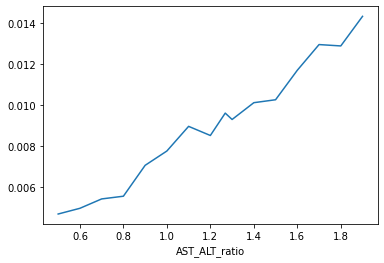

In [41]:
dem_model_bor[(dem_model_bor['AST_ALT_ratio']<2)&
             (dem_model_bor['AST_ALT_ratio']>0.4)].groupby(['AST_ALT_ratio'])['Dementia'].mean().plot()

<AxesSubplot:xlabel='AST_ALT_ratio'>

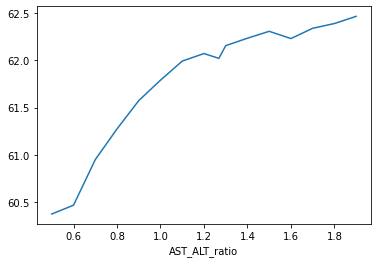

In [43]:
dem_model_bor[(dem_model_bor['AST_ALT_ratio']<2)&
             (dem_model_bor['AST_ALT_ratio']>0.4)].groupby(['AST_ALT_ratio'])\
['age_when_attended_assessment_centre_f21003'].mean().plot()

In [55]:
dem_model_bor['neutrophill_count']=\
dem_model_bor['neutrophill_count_f30140'].apply(lambda x:round(x))

<AxesSubplot:xlabel='average_total_household_income_before_tax_f738'>

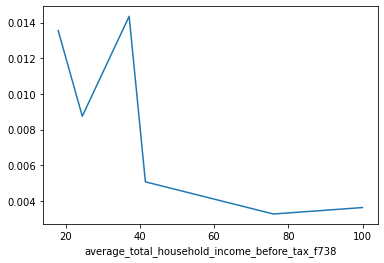

<AxesSubplot:>

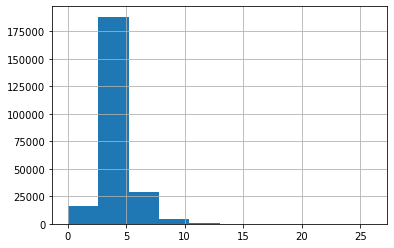

In [57]:
dem_model_bor['neutrophill_count'].hist()

<AxesSubplot:xlabel='neutrophill_count'>

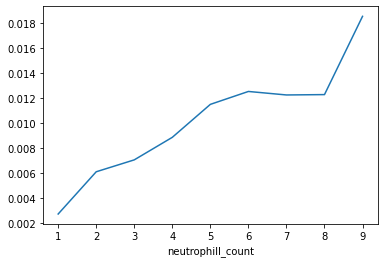

In [58]:
dem_model_bor[(dem_model_bor['neutrophill_count']>0)&
             (dem_model_bor['neutrophill_count']<10)].groupby(['neutrophill_count'])['Dementia'].mean().plot()

In [46]:
dem_model_bor.groupby(['age_when_attended_assessment_centre_f21003'])['neutrophill_count_f30140'].mean()

age_when_attended_assessment_centre_f21003
55.0    4.059049
56.0    4.086494
57.0    4.066572
58.0    4.084496
59.0    4.087477
60.0    4.114532
61.0    4.139334
62.0    4.170639
63.0    4.200165
64.0    4.203050
65.0    4.260279
66.0    4.280655
67.0    4.320404
68.0    4.318949
69.0    4.350838
70.0    4.327992
Name: neutrophill_count_f30140, dtype: float64

In [40]:
dem_model_bor[(dem_model_bor['AST_ALT_ratio']<2)&
             (dem_model_bor['AST_ALT_ratio']>0.4)].shape[0]/dem_model_bor.shape[0]

0.949441035555182

In [42]:
findcols(dem_model_bor,'age')

['average_total_household_income_before_tax_f738',
 'weekly_usage_of_mobile_phone_in_last_3_months_f1120',
 'own_or_rent_accommodation_lived_in_f680_Own with a mortgage',
 'lymphocyte_percentage_f30180',
 'age_started_wearing_glasses_or_contact_lenses_f2217',
 'age_when_attended_assessment_centre_f21003',
 'neutrophill_percentage_f30200']